In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from dotenv import load_dotenv
from monai.transforms import LoadImaged, Compose, Resized, EnsureChannelFirstd

# Add the project source to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import your custom function
from src.data.transforms import a_trous_decomposition

# Set notebook style
plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete.")

Setup complete.


In [ ]:
# Load environment variables
load_dotenv(dotenv_path='../.env')
IMAGE_ROOT_DIR = os.getenv("MIMIC_CXR_P_FOLDERS_PATH")
PROJECT_DATA_FOLDER_PATH = os.getenv("PROJECT_DATA_FOLDER_PATH")

if not all([IMAGE_ROOT_DIR, PROJECT_DATA_FOLDER_PATH]):
    raise ValueError("Please ensure all required environment variables are set.")

# --- Configuration: Set the pathology and split size to inspect ---
PATHOLOGY_TO_VISUALIZE = "Cardiomegaly"
TRAIN_SIZE_USED = 80000 # The train_size used to create the split

# --- 1. Load data and select a sample with the chosen pathology ---
print(f"Attempting to load data for pathology: '{PATHOLOGY_TO_VISUALIZE}'")

# Dynamically construct the path to the validation CSV
split_folder_name = f"split_{PATHOLOGY_TO_VISUALIZE}_{TRAIN_SIZE_USED}"
val_csv_path = os.path.join(PROJECT_DATA_FOLDER_PATH, "splits", split_folder_name, "validation.csv")

try:
    df_val = pd.read_csv(val_csv_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Validation CSV not found at '{val_csv_path}'. Please ensure you have run create_splits.py for this configuration.")

# Use the generic 'label' column to find positive cases
df_positive_cases = df_val[df_val['label'] == 1]
if df_positive_cases.empty:
    raise ValueError(f"No positive cases for '{PATHOLOGY_TO_VISUALIZE}' found in the validation split.")

# Get image path from the first positive case
sample_record = df_positive_cases.iloc[0]
subject_id = str(int(sample_record['subject_id']))
study_id = str(int(sample_record['study_id']))
dicom_id = str(sample_record['dicom_id'])
image_relative_path = os.path.join(f"p{subject_id[:2]}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}.jpg")
full_image_path = os.path.join(IMAGE_ROOT_DIR, image_relative_path)

sample_dict = {"image": full_image_path}
print(f"Successfully located image with '{PATHOLOGY_TO_VISUALIZE}':\n{full_image_path}")

Successfully located image with a fracture:
E:/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/files\p19\p19175595\s52445151\468a1675-344a56da-7cf12651-0344086a-8454a87a.jpg


In [3]:
# Define preprocessing transforms
IMAGE_SIZE = (512, 512)
preprocess_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Resized(keys=["image"], spatial_size=IMAGE_SIZE)
])

# Load and preprocess the image
preprocessed_dict = preprocess_transforms(sample_dict)
image_tensor = preprocessed_dict['image']

# Convert to a 2D NumPy array for processing
image_np = image_tensor.squeeze().numpy()

print(f"Image preprocessed to shape: {image_np.shape}")

Image preprocessed to shape: (512, 512)


In [4]:
# Define the number of scales for decomposition
N_SCALES = 4

# Apply the À Trous decomposition
# The output is a list of detail layers and the final residual layer
decomposed_layers = a_trous_decomposition(image_np, scales=N_SCALES)

print(f"Decomposition complete.")
print(f"Number of generated layers: {len(decomposed_layers)} ({N_SCALES} detail layers + 1 residual layer)")

Decomposition complete.
Number of generated layers: 5 (4 detail layers + 1 residual layer)


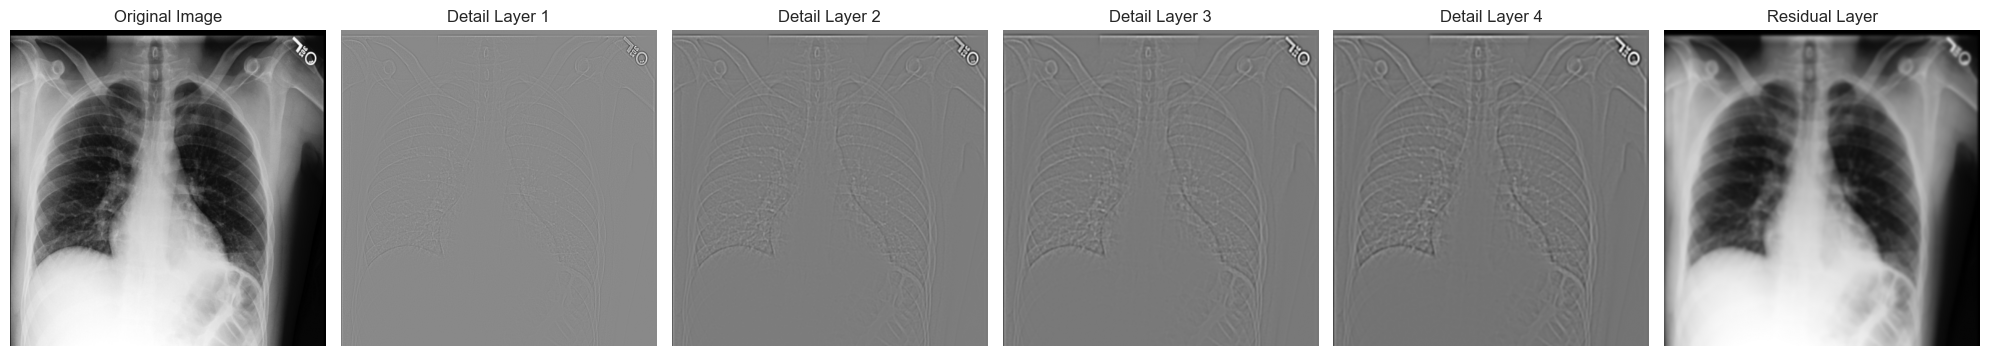

In [8]:
# Prepare for plotting
# We will plot the original image, N_SCALES detail layers, and 1 residual
num_plots = N_SCALES + 2
fig, axes = plt.subplots(1, num_plots, figsize=(20, 4))

# Plot Original Image
axes[0].imshow(image_np.T, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot Detail Layers
for i in range(N_SCALES):
    ax = axes[i + 1]
    # Use a diverging colormap to highlight positive and negative values
    im = ax.imshow(decomposed_layers[i].T, cmap='gray')
    ax.set_title(f'Detail Layer {i+1}')
    ax.axis('off')

# Plot Residual Layer
axes[-1].imshow(decomposed_layers[-1].T, cmap='gray')
axes[-1].set_title('Residual Layer')
axes[-1].axis('off')

plt.tight_layout()
plt.show()